# Bayesian filtering: optimizing the key functions

## Create the data structures and functions

Load the libraries we need

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import misc
import matplotlib.pyplot as plt
import math
import time

Define the state variables $\mathbf{X}$ and the sensor variables $\mathbf{Y}$. In this case, the state variables consist of the $x$ and $y$ positions of the object and the sensor variables are the distances to the object measured by sensors in the four corners of a square: lower left, upper left, lower right, and upper right.

In [2]:
x_names = [
    'pos_x',
    'pos_y'
]

x_names_long = [
    '$x$ position',
    '$y$ position'
]

y_names = [
    'LL',
    'UL',
    'LR',
    'UR'
]

y_names_long = [
    'Lower left',
    'Upper left',
    'Lower right',
    'Upper right'
]

In [3]:
num_x_vars = len(x_names)
num_y_vars = len(y_names)

Define the parameters of the initial state, the transition model and the sensor response model. In this case, the initial state is a two-dimensional Gaussian with mean of $(0,0)$ and a standard deviation of $\sigma_i = 0.1$. The transition model is a two-dimensional Gaussian random walk with a standard deviation of $\sigma_t = 0.1$. The sensor response model is that the sensors are placed at $(-1, -1)$, $(-1, 1)$, $(1, -1)$, and $(1, 1)$ and they measure the distance to the object with Gaussian error $\sigma_m = 0.2$.

In [4]:
initial_position = np.array([0.0, 0.0])
initial_error = 0.1
drift = 0.1
sensor_positions = np.array([
    [-1.0, -1.0],
    [-1.0, 1.0],
    [1.0, -1.0],
    [1.0, 1.0]
])
sensor_error = 0.2

Define a function that generates samples of the initial state $\mathbf{X}_0$. We have a choice of two multivariate normal sampling functions, one from the `scipy` package and the other from the `numpy` package. We'll test them both.

In [5]:
initial_covariance = np.diagflat(np.repeat(initial_error**2, 2))

In [6]:
def x_initial_sample_scipy():
    return stats.multivariate_normal.rvs(mean=initial_position, cov=initial_covariance)

In [7]:
def x_initial_sample_numpy():
    return np.random.multivariate_normal(initial_position, initial_covariance)

Generate 1,000 samples and check that they have the properties we expect.

In [8]:
time_start = time.clock()
x_initial_samples_scipy = np.array([x_initial_sample_scipy() for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.202105513768


In [9]:
time_start = time.clock()
x_initial_samples_numpy = np.array([x_initial_sample_numpy() for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.162370490722


The functions look similar in terms of speed.

In [10]:
np.mean(x_initial_samples_scipy, 0)

array([-0.000864  ,  0.00087146])

In [11]:
np.mean(x_initial_samples_numpy, 0)

array([-0.00124882,  0.00389676])

In [12]:
np.std(x_initial_samples_scipy, 0)

array([ 0.10376015,  0.1021869 ])

In [13]:
np.std(x_initial_samples_numpy, 0)

array([ 0.10591112,  0.09842581])

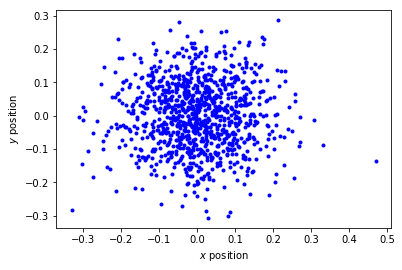

In [14]:
plt.plot(x_initial_samples_scipy[:,0], x_initial_samples_scipy[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

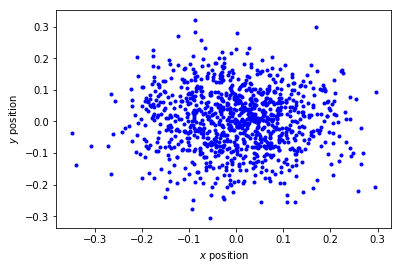

In [15]:
plt.plot(x_initial_samples_numpy[:,0], x_initial_samples_numpy[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

They both give the behavior we expect. We'll probably go with the `numpy` version because it requires less overhead (we're loading `numpy` anyway and `scipy` is built on `numpy`).

Define a function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$. Again, we try both the `scipy` and `numpy` versions.

In [16]:
x_bar_x_prev_covariance = np.diagflat(np.repeat(drift**2,2))

In [17]:
def x_bar_x_prev_sample_scipy(x_prev):
    return stats.multivariate_normal.rvs(mean=x_prev, cov=x_bar_x_prev_covariance)

In [18]:
def x_bar_x_prev_sample_numpy(x_prev):
    return np.random.multivariate_normal(x_prev, x_bar_x_prev_covariance)

Generate 1,000 samples (with $\mathbf{X}_{t-1}$ chosen arbitrarily) to make sure they have the properties we expect.

In [19]:
time_start = time.clock()
x_bar_x_prev_samples_scipy = np.array([x_bar_x_prev_sample_scipy(np.array([0.1, -0.2])) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.215115001551


In [20]:
time_start = time.clock()
x_bar_x_prev_samples_numpy = np.array([x_bar_x_prev_sample_numpy(np.array([0.1, -0.2])) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.165313636133


In [21]:
np.mean(x_bar_x_prev_samples_scipy, 0)

array([ 0.09786608, -0.19560846])

In [22]:
np.mean(x_bar_x_prev_samples_numpy, 0)

array([ 0.09753908, -0.20235164])

In [23]:
np.std(x_bar_x_prev_samples_scipy, 0)

array([ 0.09670889,  0.10309316])

In [24]:
np.std(x_bar_x_prev_samples_numpy, 0)

array([ 0.09843867,  0.10546896])

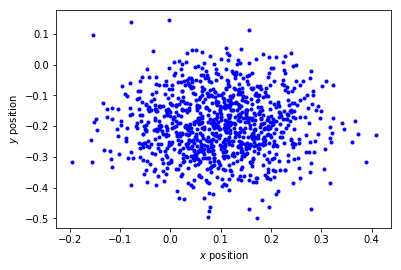

In [25]:
plt.plot(x_bar_x_prev_samples_scipy[:,0], x_bar_x_prev_samples_scipy[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

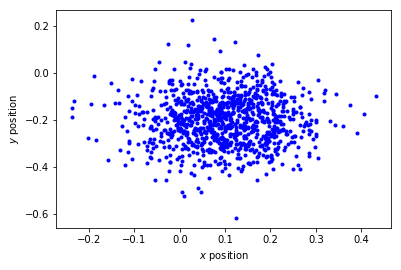

In [26]:
plt.plot(x_bar_x_prev_samples_numpy[:,0], x_bar_x_prev_samples_numpy[:,1], 'b.')
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

As before, the two different versions of the function perform very similarly. We'll use the `numpy` version.

Define a function that returns the distances to the four sensors given $\mathbf{X}$.

In [27]:
def distances_to_sensors(x):
    return np.linalg.norm(np.tile(x,num_y_vars).reshape((num_y_vars, num_x_vars)) - sensor_positions, axis=1)

Try this out for a couple of values of $\mathbf{X}$ to make sure we get the results we expect.

In [28]:
distances_to_sensors(np.array([0, 0]))

array([ 1.41421356,  1.41421356,  1.41421356,  1.41421356])

In [29]:
math.sqrt(2)

1.4142135623730951

In [30]:
distances_to_sensors(np.array([-1, 0]))

array([ 1.        ,  1.        ,  2.23606798,  2.23606798])

In [31]:
math.sqrt(5)

2.23606797749979

Define a function that generates samples of the sensor readings $\mathbf{Y}$ given $\mathbf{X}$. Again, we'll try both the `scipy` and `numpy` versions.

In [32]:
y_bar_x_covariance = np.diagflat(np.repeat(sensor_error**2,4))

In [33]:
def y_bar_x_sample_scipy(x):
    distances = distances_to_sensors(x)
    return stats.multivariate_normal.rvs(mean=distances, cov=y_bar_x_covariance)

In [34]:
def y_bar_x_sample_numpy(x):
    distances = distances_to_sensors(x)
    return np.random.multivariate_normal(distances, y_bar_x_covariance)

Generate 1,000 samples (with $\mathbf{X}$ chosen arbitrarily) to make sure they have the properties we expect.

In [35]:
time_start = time.clock()
y_bar_x_samples_scipy = np.array([y_bar_x_sample_scipy(np.array([-1, 0])) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.345153132735


In [36]:
time_start = time.clock()
y_bar_x_samples_numpy = np.array([y_bar_x_sample_numpy(np.array([-1, 0])) for i in range(1000)])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.211747322988


In [37]:
np.mean(y_bar_x_samples_scipy, 0)

array([ 0.99911682,  1.00309968,  2.24106368,  2.23433677])

In [38]:
np.mean(y_bar_x_samples_numpy, 0)

array([ 0.99939209,  0.99996654,  2.22855213,  2.2388967 ])

In [39]:
np.std(y_bar_x_samples_scipy, 0)

array([ 0.19335019,  0.20588165,  0.20020765,  0.19741208])

In [40]:
np.std(y_bar_x_samples_numpy, 0)

array([ 0.19653114,  0.19924843,  0.20007842,  0.20237537])

As before, the two different versions of the function perform very similarly. We'll go with the `numpy` version.

Define a generic Gaussian probability density function. Here we have two interacting choices. We can use the `scipy` function or we can just define the function ourselves using base Python operations, and we can work with probabilities or log-probabilities (the latter is often necessary to prevent underflow problems).

In [41]:
def pdf_gaussian_scipy(x, mean, sd):
    return stats.norm.pdf(x, loc=mean, scale=sd)

In [42]:
def pdf_gaussian_base(x, mean, sd):
    return math.exp(-(x-mean)**2/(2*sd**2))/(math.sqrt(2*math.pi)*sd)

In [43]:
def log_pdf_gaussian_scipy(x, mean, sd):
    return stats.norm.logpdf(x, loc=mean, scale=sd)

In [44]:
def log_pdf_gaussian_base(x, mean, sd):
    return -(x-mean)**2/(2*sd**2) - math.log(math.sqrt(2*math.pi)*sd)

Plot the function to make sure it has the shape and normalization we expect.

In [45]:
x_range = np.arange(-10.0, 0.0, 0.01)

In [46]:
time_start = time.clock()
f_range_scipy = np.array([pdf_gaussian_scipy(x, -5.0, 1.0) for x in x_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.142859885713


In [47]:
time_start = time.clock()
f_range_base = np.array([pdf_gaussian_base(x, -5.0, 1.0) for x in x_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.00322431862429


In [48]:
time_start = time.clock()
log_f_range_scipy = np.array([log_pdf_gaussian_scipy(x, -5.0, 1.0) for x in x_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.115368910776


In [49]:
time_start = time.clock()
log_f_range_base = np.array([log_pdf_gaussian_base(x, -5.0, 1.0) for x in x_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.00328106526675


Here we see a clear speed difference. In speed terms, it doesn't seem make much difference whether we work with probabilities or log-probabilities, but the version of the function that uses base Python is significantly faster than the `scipy` version. We'll go with the base Python version.

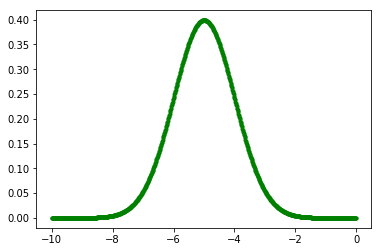

In [50]:
plt.plot(x_range, f_range_scipy, 'g.')
plt.show()

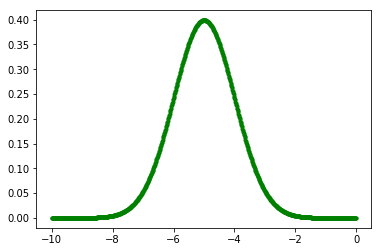

In [51]:
plt.plot(x_range, f_range_base, 'g.')
plt.show()

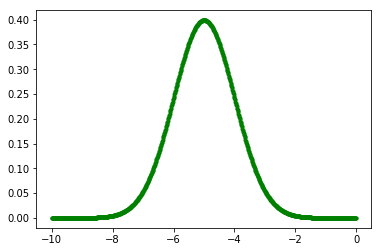

In [52]:
plt.plot(x_range, np.exp(log_f_range_scipy), 'g.')
plt.show()

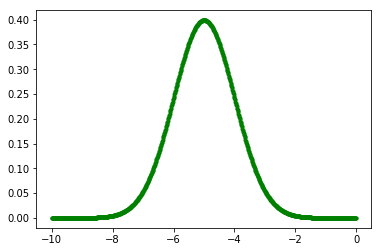

In [53]:
plt.plot(x_range, np.exp(log_f_range_base), 'g.')
plt.show()

All versions of the function give identical results. We should clearly go with the base Python version rather than the `scipy` version for speed. There is no clear performance difference when using probabilities vs. log-probabilities, but we suspect we'll end up having to use the latter when we move to much higher-dimensional spaces at the probability density at any particular point in this higher-dimensional space starts to get small.

Define $f(\mathbf{Y} | \mathbf{X})$, the probability density function for the sensor readings $\mathbf{Y}$ given the state $\mathbf{X}$. We'll continue to use all four versions of the function in case we see any differences in performance.

In [54]:
def f_y_bar_x_scipy(x, y):
    distances = distances_to_sensors(x)
    probability_densities = np.array([pdf_gaussian_scipy(y[i], distances[i], sensor_error) for i in range(num_y_vars)])
    return np.product(probability_densities)

In [55]:
def f_y_bar_x_base(x, y):
    distances = distances_to_sensors(x)
    probability_densities = np.array([pdf_gaussian_base(y[i], distances[i], sensor_error) for i in range(num_y_vars)])
    return np.product(probability_densities)

In [56]:
def log_f_y_bar_x_scipy(x, y):
    distances = distances_to_sensors(x)
    log_probability_densities = np.array([log_pdf_gaussian_scipy(y[i], distances[i], sensor_error) for i in range(num_y_vars)])
    return np.sum(log_probability_densities)

In [57]:
def log_f_y_bar_x_base(x, y):
    distances = distances_to_sensors(x)
    log_probability_densities = np.array([log_pdf_gaussian_base(y[i], distances[i], sensor_error) for i in range(num_y_vars)])
    return np.sum(log_probability_densities)

Plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on the lower-left sensor reading, holding the values of all of the other sensor readings fixed, to make sure it has the shape we expect.

In [58]:
LL_range = np.arange(-2, 4, 0.01)

In [59]:
time_start = time.clock()
f_range_scipy = np.array([f_y_bar_x_scipy(np.array([0, 0]), np.array([LL, 1.4142, 1.4142, 1.4142])) for LL in LL_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.315761785275


In [60]:
time_start = time.clock()
f_range_base = np.array([f_y_bar_x_base(np.array([0, 0]), np.array([LL, 1.4142, 1.4142, 1.4142])) for LL in LL_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0451643540632


In [61]:
time_start = time.clock()
log_f_range_scipy = np.array([log_f_y_bar_x_scipy(np.array([0, 0]), np.array([LL, 1.4142, 1.4142, 1.4142])) for LL in LL_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.353761129062


In [62]:
time_start = time.clock()
log_f_range_base = np.array([log_f_y_bar_x_base(np.array([0, 0]), np.array([LL, 1.4142, 1.4142, 1.4142])) for LL in LL_range])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0508961916176


As we saw before, the base Python version of the function is much faster than the `scipy` version.

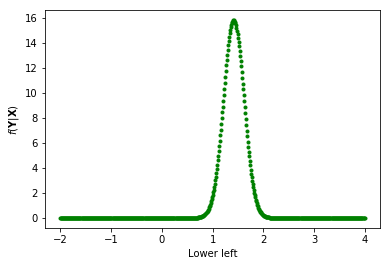

In [63]:
plt.plot(LL_range, f_range_scipy, 'g.')
plt.xlabel(y_names_long[0])
plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
plt.show()

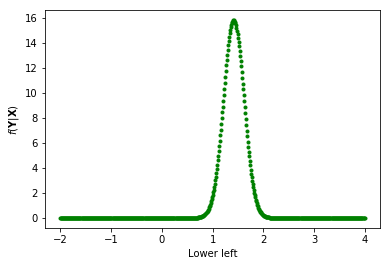

In [64]:
plt.plot(LL_range, f_range_base, 'g.')
plt.xlabel(y_names_long[0])
plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
plt.show()

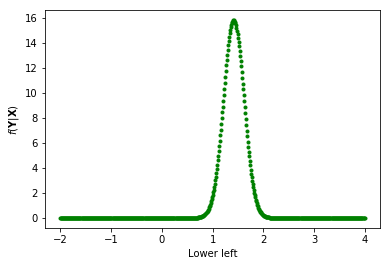

In [65]:
plt.plot(LL_range, np.exp(log_f_range_scipy), 'g.')
plt.xlabel(y_names_long[0])
plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
plt.show()

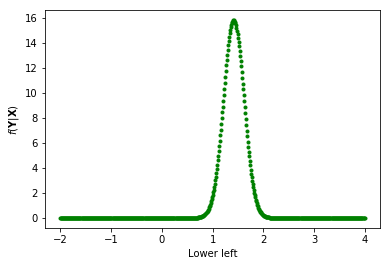

In [66]:
plt.plot(LL_range, np.exp(log_f_range_base), 'g.')
plt.xlabel(y_names_long[0])
plt.ylabel('$f(\mathbf{Y} | \mathbf{X})$')
plt.show()

Check to make sure that $f(\mathbf{Y} | \mathbf{X})$ is normalized properly by evaluating the crude numerical integral of the function over $\mathbf{Y}$

In [67]:
time_start = time.clock()
integral = 0
for LL in np.arange(0, 3, 0.1):
    print LL
    for UL in np.arange(0, 3, 0.1):
        for LR in np.arange(0, 3, 0.1):
            for UR in np.arange(0, 3, 0.1):
                integral = integral + f_y_bar_x_scipy(np.array([0, 0]), np.array([LL, UL, LR, UR]))*0.0001
print'Time elapsed = {}'.format(time.clock()-time_start)
print 'Integral = {}'.format(integral)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
Time elapsed = 348.613897125
Integral = 0.999999999999


In [68]:
time_start = time.clock()
integral = 0
for LL in np.arange(0, 3, 0.1):
    print LL
    for UL in np.arange(0, 3, 0.1):
        for LR in np.arange(0, 3, 0.1):
            for UR in np.arange(0, 3, 0.1):
                integral = integral + f_y_bar_x_base(np.array([0, 0]), np.array([LL, UL, LR, UR]))*0.0001
print'Time elapsed = {}'.format(time.clock()-time_start)
print 'Integral = {}'.format(integral)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
Time elapsed = 39.3762157328
Integral = 0.999999999999


In [69]:
time_start = time.clock()
integral = 0
for LL in np.arange(0, 3, 0.1):
    print LL
    for UL in np.arange(0, 3, 0.1):
        for LR in np.arange(0, 3, 0.1):
            for UR in np.arange(0, 3, 0.1):
                integral = integral + math.exp(log_f_y_bar_x_scipy(np.array([0, 0]), np.array([LL, UL, LR, UR])))*0.0001
print'Time elapsed = {}'.format(time.clock()-time_start)
print 'Integral = {}'.format(integral)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
Time elapsed = 339.118610723
Integral = 0.999999999999


In [70]:
time_start = time.clock()
integral = 0
for LL in np.arange(0, 3, 0.1):
    print LL
    for UL in np.arange(0, 3, 0.1):
        for LR in np.arange(0, 3, 0.1):
            for UR in np.arange(0, 3, 0.1):
                integral = integral + math.exp(log_f_y_bar_x_base(np.array([0, 0]), np.array([LL, UL, LR, UR])))*0.0001
print'Time elapsed = {}'.format(time.clock()-time_start)
print 'Integral = {}'.format(integral)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
Time elapsed = 39.6498045228
Integral = 0.999999999999


The speed differences are very stark here.

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Set the number of timesteps and initialize the variables.

In [71]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_t = np.zeros((num_timesteps, num_x_vars), dtype='float')
y_t = np.zeros((num_timesteps, num_y_vars), dtype='float')

Calculate the data for $t=0$.

In [72]:
t[0] = 0.0

In [73]:
x_t[0] = x_initial_sample_numpy()

In [74]:
y_t[0] = y_bar_x_sample_numpy(x_t[0])

Calculate the data for $t>0$.

In [75]:
timestep_size = 1.0

In [76]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_t[t_index] = x_bar_x_prev_sample_numpy(x_t[t_index - 1])
    y_t[t_index] = y_bar_x_sample_numpy(x_t[t_index])

Plot the data to make sure it has the properties we expect.

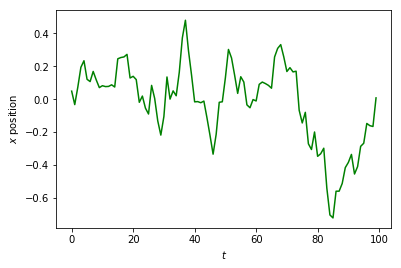

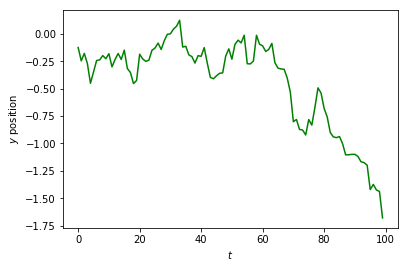

In [77]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:, x_var_index], 'g-')
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.show()

In [78]:
distances_t = np.array([distances_to_sensors(x) for x in x_t])

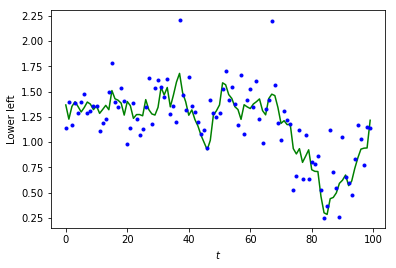

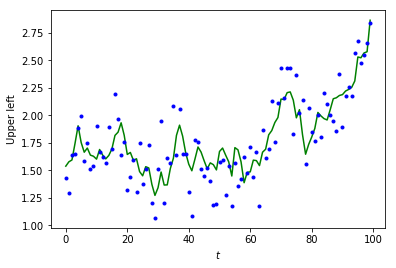

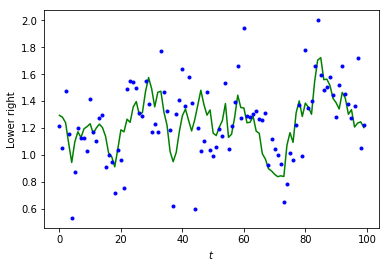

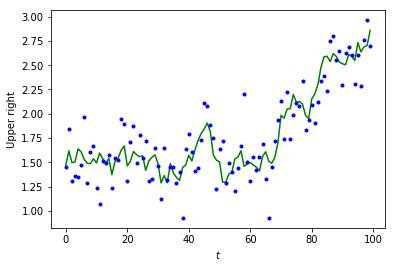

In [79]:
for y_var_index in range(num_y_vars):
    plt.plot(t, distances_t[:, y_var_index], 'g-')
    plt.plot(t, y_t[:, y_var_index], 'b.')
    plt.xlabel('$t$')
    plt.ylabel(y_names_long[y_var_index])
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \mathbf{Y}_1, \ldots, \mathbf{Y}_t)$ using a particle filter

Set the number of particles and initialize variables. We'll continue to test all four versions of the probability density function.

In [80]:
num_particles = 50
particle_values_scipy = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
particle_values_base = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
particle_values_log_scipy = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
particle_values_log_base = np.zeros((num_timesteps, num_particles, num_x_vars), dtype = 'float')
particle_weights_scipy = np.zeros((num_timesteps, num_particles), dtype = 'float')
particle_weights_base = np.zeros((num_timesteps, num_particles), dtype = 'float')
log_particle_weights_scipy = np.zeros((num_timesteps, num_particles), dtype = 'float')
log_particle_weights_base = np.zeros((num_timesteps, num_particles), dtype = 'float')

Generate the particles for the initial state $\mathbf{X}_0$.

In [81]:
time_start = time.clock()
for particle_index in range(num_particles):
    particle_values_scipy[0, particle_index] = x_initial_sample_numpy()
    particle_values_base[0, particle_index] = particle_values_scipy[0, particle_index]
    particle_values_log_scipy[0, particle_index] = particle_values_scipy[0, particle_index]
    particle_values_log_base[0, particle_index] = particle_values_scipy[0, particle_index]
    particle_weights_scipy[0, particle_index] = f_y_bar_x_scipy(particle_values_scipy[0, particle_index], y_t[0])
    particle_weights_base[0, particle_index] = f_y_bar_x_base(particle_values_base[0, particle_index], y_t[0])
    log_particle_weights_scipy[0, particle_index] = log_f_y_bar_x_scipy(particle_values_log_scipy[0, particle_index], y_t[0])
    log_particle_weights_base[0, particle_index] = log_f_y_bar_x_base(particle_values_log_base[0, particle_index], y_t[0])
particle_weights_scipy[0] = particle_weights_scipy[0]/np.sum(particle_weights_scipy[0])
particle_weights_base[0] = particle_weights_base[0]/np.sum(particle_weights_base[0])
log_particle_weights_scipy[0] = log_particle_weights_scipy[0] - misc.logsumexp(log_particle_weights_scipy[0])
log_particle_weights_base[0] = log_particle_weights_base[0] - misc.logsumexp(log_particle_weights_base[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0993923842592


Check to see that these particles have the properties we expect. At this stage, because we haven't yet started to sample, we expect all four approaches to give identical results.

In [82]:
np.sum(particle_values_base[0] - particle_values_scipy[0])

0.0

In [83]:
np.sum(particle_values_log_scipy[0] - particle_values_scipy[0])

0.0

In [84]:
np.sum(particle_values_log_base[0] - particle_values_scipy[0])

0.0

In [85]:
particle_weights_scipy[0]

array([ 0.00976795,  0.0218455 ,  0.00793425,  0.05302614,  0.00579709,
        0.00635235,  0.02753123,  0.01376969,  0.00204527,  0.02540112,
        0.02464442,  0.00413912,  0.01717613,  0.03058326,  0.00158569,
        0.01366331,  0.02005893,  0.0459812 ,  0.02016194,  0.02830805,
        0.02083236,  0.02583078,  0.0484561 ,  0.00288663,  0.0242965 ,
        0.02562654,  0.01080027,  0.00678578,  0.03114427,  0.0461843 ,
        0.02589377,  0.0121262 ,  0.00293121,  0.00743581,  0.02681659,
        0.02179483,  0.02133585,  0.02243895,  0.0025544 ,  0.03567997,
        0.01442789,  0.02960313,  0.02135648,  0.05040802,  0.00215811,
        0.02186387,  0.00089857,  0.01715268,  0.02169592,  0.01881158])

In [86]:
particle_weights_base[0]

array([ 0.00976795,  0.0218455 ,  0.00793425,  0.05302614,  0.00579709,
        0.00635235,  0.02753123,  0.01376969,  0.00204527,  0.02540112,
        0.02464442,  0.00413912,  0.01717613,  0.03058326,  0.00158569,
        0.01366331,  0.02005893,  0.0459812 ,  0.02016194,  0.02830805,
        0.02083236,  0.02583078,  0.0484561 ,  0.00288663,  0.0242965 ,
        0.02562654,  0.01080027,  0.00678578,  0.03114427,  0.0461843 ,
        0.02589377,  0.0121262 ,  0.00293121,  0.00743581,  0.02681659,
        0.02179483,  0.02133585,  0.02243895,  0.0025544 ,  0.03567997,
        0.01442789,  0.02960313,  0.02135648,  0.05040802,  0.00215811,
        0.02186387,  0.00089857,  0.01715268,  0.02169592,  0.01881158])

In [87]:
np.exp(log_particle_weights_scipy[0])

array([ 0.00976795,  0.0218455 ,  0.00793425,  0.05302614,  0.00579709,
        0.00635235,  0.02753123,  0.01376969,  0.00204527,  0.02540112,
        0.02464442,  0.00413912,  0.01717613,  0.03058326,  0.00158569,
        0.01366331,  0.02005893,  0.0459812 ,  0.02016194,  0.02830805,
        0.02083236,  0.02583078,  0.0484561 ,  0.00288663,  0.0242965 ,
        0.02562654,  0.01080027,  0.00678578,  0.03114427,  0.0461843 ,
        0.02589377,  0.0121262 ,  0.00293121,  0.00743581,  0.02681659,
        0.02179483,  0.02133585,  0.02243895,  0.0025544 ,  0.03567997,
        0.01442789,  0.02960313,  0.02135648,  0.05040802,  0.00215811,
        0.02186387,  0.00089857,  0.01715268,  0.02169592,  0.01881158])

In [88]:
np.exp(log_particle_weights_base[0])

array([ 0.00976795,  0.0218455 ,  0.00793425,  0.05302614,  0.00579709,
        0.00635235,  0.02753123,  0.01376969,  0.00204527,  0.02540112,
        0.02464442,  0.00413912,  0.01717613,  0.03058326,  0.00158569,
        0.01366331,  0.02005893,  0.0459812 ,  0.02016194,  0.02830805,
        0.02083236,  0.02583078,  0.0484561 ,  0.00288663,  0.0242965 ,
        0.02562654,  0.01080027,  0.00678578,  0.03114427,  0.0461843 ,
        0.02589377,  0.0121262 ,  0.00293121,  0.00743581,  0.02681659,
        0.02179483,  0.02133585,  0.02243895,  0.0025544 ,  0.03567997,
        0.01442789,  0.02960313,  0.02135648,  0.05040802,  0.00215811,
        0.02186387,  0.00089857,  0.01715268,  0.02169592,  0.01881158])

In [89]:
np.sum(particle_weights_scipy[0])

1.0

In [90]:
np.sum(particle_weights_base[0])

1.0

In [91]:
math.exp(misc.logsumexp(log_particle_weights_scipy[0]))

0.9999999999999996

In [92]:
math.exp(misc.logsumexp(log_particle_weights_base[0]))

1.0

In [93]:
x_initial_mean_scipy = np.average(particle_values_scipy[0], axis=0, weights = particle_weights_scipy[0])

In [94]:
x_initial_mean_base = np.average(particle_values_base[0], axis=0, weights = particle_weights_base[0])

In [95]:
x_initial_mean_log_scipy = np.average(particle_values_log_scipy[0], axis=0, weights = np.exp(log_particle_weights_scipy[0]))

In [96]:
x_initial_mean_log_base = np.average(particle_values_log_base[0], axis=0, weights = np.exp(log_particle_weights_base[0]))

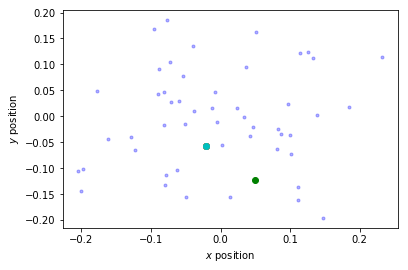

In [97]:
plt.plot(x_t[0,0],x_t[0,1],'go')
plt.plot(x_initial_mean_scipy[0], x_initial_mean_scipy[1], 'bo')
plt.plot(x_initial_mean_base[0], x_initial_mean_base[1], 'ro')
plt.plot(x_initial_mean_log_scipy[0], x_initial_mean_log_scipy[1], 'yo')
plt.plot(x_initial_mean_log_base[0], x_initial_mean_log_base[1], 'co')
plt.plot(particle_values_scipy[0,:,0],particle_values_scipy[0,:,1], 'b.', alpha=0.3)
plt.xlabel(x_names_long[0])
plt.ylabel(x_names_long[1])
plt.show()

This looks as we expect. The particles are distributed according to the initial probability distribution (i.e., centered around $(0,0)$, not around the actual position of the particle). The weighted means of the particles incorporate the sensor readings and so are closer to the actual position, but not on top of it due to both sensor error and sampling error. The real test is whether the particles converge and track the actual state as we generate successive sets of particles.

Calculate the particles for all times $t>0$.

In [98]:
time_start = time.clock()
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values_scipy[t_index - 1,
                                                  np.random.choice(num_particles,
                                                                   p=particle_weights_scipy[t_index - 1])]
        particle_values_scipy[t_index, particle_index] = x_bar_x_prev_sample_numpy(previous_particle)
        particle_weights_scipy[t_index, particle_index] = f_y_bar_x_scipy(particle_values_scipy[t_index, particle_index],
                                                                          y_t[t_index])
    particle_weights_scipy[t_index] = particle_weights_scipy[t_index]/np.sum(particle_weights_scipy[t_index])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 3.35560859494


In [99]:
time_start = time.clock()
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values_base[t_index - 1,
                                                 np.random.choice(num_particles,
                                                                  p=particle_weights_base[t_index - 1])]
        particle_values_base[t_index, particle_index] = x_bar_x_prev_sample_numpy(previous_particle)
        particle_weights_base[t_index, particle_index] = f_y_bar_x_base(particle_values_base[t_index, particle_index],
                                                                        y_t[t_index])
    particle_weights_base[t_index] = particle_weights_base[t_index]/np.sum(particle_weights_base[t_index])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 1.30017608526


In [100]:
time_start = time.clock()
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values_log_scipy[t_index - 1,
                                                      np.random.choice(num_particles,
                                                                       p=np.exp(log_particle_weights_scipy[t_index - 1]))]
        particle_values_log_scipy[t_index, particle_index] = x_bar_x_prev_sample_numpy(previous_particle)
        log_particle_weights_scipy[t_index, particle_index] = log_f_y_bar_x_scipy(particle_values_log_scipy[t_index, particle_index], y_t[t_index])
    log_particle_weights_scipy[t_index] = log_particle_weights_scipy[t_index]- misc.logsumexp(log_particle_weights_scipy[t_index])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 3.67503629865


In [101]:
time_start = time.clock()
for t_index in range(1, num_timesteps):
    for particle_index in range(num_particles):
        previous_particle = particle_values_log_base[t_index - 1,
                                                      np.random.choice(num_particles,
                                                                       p=np.exp(log_particle_weights_base[t_index - 1]))]
        particle_values_log_base[t_index, particle_index] = x_bar_x_prev_sample_numpy(previous_particle)
        log_particle_weights_base[t_index, particle_index] = log_f_y_bar_x_base(particle_values_log_base[t_index, particle_index], y_t[t_index])
    log_particle_weights_base[t_index] = log_particle_weights_base[t_index]- misc.logsumexp(log_particle_weights_base[t_index])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 1.59688550533


Calculate the sample means and sample standard deviations of the particles at each time $t$.

In [102]:
x_mean_particle_scipy = np.average(
    particle_values_scipy, 
    axis=1, 
    weights=np.repeat(particle_weights_scipy, 2).reshape((num_timesteps, num_particles, 2))
)

In [103]:
x_mean_particle_base = np.average(
    particle_values_base, 
    axis=1, 
    weights=np.repeat(particle_weights_base, 2).reshape((num_timesteps, num_particles, 2))
)

In [104]:
x_mean_particle_log_scipy = np.average(
    particle_values_log_scipy, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights_scipy), 2).reshape((num_timesteps, num_particles, 2))
)

In [105]:
x_mean_particle_log_base = np.average(
    particle_values_log_base, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights_base), 2).reshape((num_timesteps, num_particles, 2))
)

In [106]:
x_squared_mean_particle_scipy = np.average(
    np.square(particle_values_scipy), 
    axis=1, 
    weights=np.repeat(particle_weights_scipy, 2).reshape((num_timesteps, num_particles, 2))
)

In [107]:
x_squared_mean_particle_base = np.average(
    np.square(particle_values_base), 
    axis=1, 
    weights=np.repeat(particle_weights_base, 2).reshape((num_timesteps, num_particles, 2))
)

In [108]:
x_squared_mean_particle_log_scipy = np.average(
    np.square(particle_values_log_scipy), 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights_scipy), 2).reshape((num_timesteps, num_particles, 2))
)

In [109]:
x_squared_mean_particle_log_base = np.average(
    np.square(particle_values_log_base), 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights_base), 2).reshape((num_timesteps, num_particles, 2))
)

In [110]:
x_sd_particle_scipy = np.sqrt(x_squared_mean_particle_scipy - np.square(x_mean_particle_scipy))

In [111]:
x_sd_particle_base = np.sqrt(x_squared_mean_particle_base - np.square(x_mean_particle_base))

In [112]:
x_sd_particle_log_scipy = np.sqrt(x_squared_mean_particle_log_scipy - np.square(x_mean_particle_log_scipy))

In [113]:
x_sd_particle_log_base = np.sqrt(x_squared_mean_particle_log_base - np.square(x_mean_particle_log_base))

Plot these sample means against the actual values of $\mathbf{X}_t$.

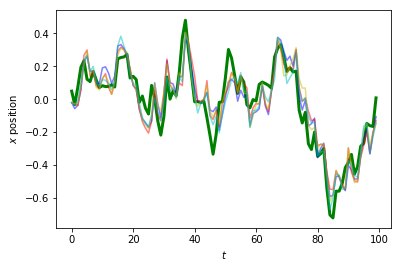

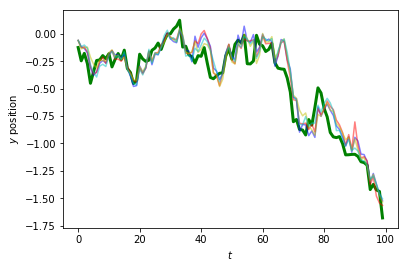

In [114]:
for x_var_index in range(num_x_vars):
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0)
    plt.plot(t, x_mean_particle_scipy[:,x_var_index], 'b-', alpha=0.5)
    plt.plot(t, x_mean_particle_base[:,x_var_index], 'r-', alpha=0.5)
    plt.plot(t, x_mean_particle_log_scipy[:,x_var_index], 'y-', alpha=0.5)
    plt.plot(t, x_mean_particle_log_base[:,x_var_index], 'c-', alpha=0.5)
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.savefig('particle_means_continuous_{}.pdf'.format(x_names[x_var_index]))
    plt.show()


Plot the sample confidence regions against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

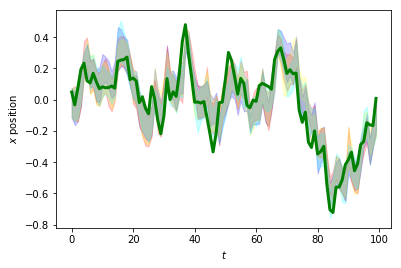

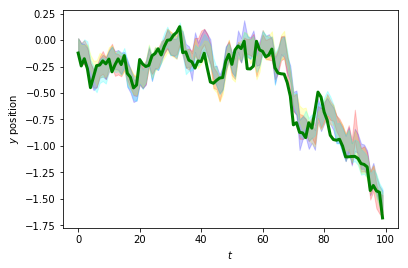

In [115]:
for x_var_index in range(num_x_vars):
    plt.fill_between(
        t,
        x_mean_particle_scipy[:,x_var_index] - x_sd_particle_scipy[:, x_var_index],
        x_mean_particle_scipy[:,x_var_index] + x_sd_particle_scipy[:, x_var_index],
        color='blue',
        alpha=0.2
    )
    plt.fill_between(
        t,
        x_mean_particle_base[:,x_var_index] - x_sd_particle_base[:, x_var_index],
        x_mean_particle_base[:,x_var_index] + x_sd_particle_base[:, x_var_index],
        color='red',
        alpha=0.2
    )
    plt.fill_between(
        t,
        x_mean_particle_log_scipy[:,x_var_index] - x_sd_particle_log_scipy[:, x_var_index],
        x_mean_particle_log_scipy[:,x_var_index] + x_sd_particle_log_scipy[:, x_var_index],
        color='yellow',
        alpha=0.2
    )
    plt.fill_between(
        t,
        x_mean_particle_log_base[:,x_var_index] - x_sd_particle_log_base[:, x_var_index],
        x_mean_particle_log_base[:,x_var_index] + x_sd_particle_log_base[:, x_var_index],
        color='cyan',
        alpha=0.2
    )
    plt.plot(t, x_t[:,x_var_index], 'g-', linewidth=3.0)
    plt.xlabel('$t$')
    plt.ylabel(x_names_long[x_var_index])
    plt.savefig('particle_crs_continuous_{}.pdf'.format(x_names[x_var_index]))
    plt.show()


The particle filter tracks extremely well, even with only 50 particles. The above results suggest that we should use the `numpy` version of the multivariate normal sampling function and the base Python version of the normal PDF function. We didn't see any clear differences yet when using probabilities vs. log-probabilties, but it's reassuring that they give identical results, because we suspect we'll need to use the latter when we go to high dimensions.